In [1]:
import scanpy as sc
import scrublet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [26]:
DATA_PATH = '/home/vpetukhov/data/human_ovarian_cancer/scRNAseq/'
!mkdir -p $DATA_PATH/processed

In [8]:
emb = pd.read_csv(
    f'{DATA_PATH}/analysis/umap/gene_expression_2_components/projection.csv',
    index_col='Barcode'
)

In [11]:
ad = sc.read_10x_h5(f'{DATA_PATH}/17k_Ovarian_Cancer_scFFPE_count_filtered_feature_bc_matrix.h5')
ad

/home/vpetukhov/miniforge3/envs/scrublet/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vpetukhov/miniforge3/envs/scrublet/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 17553 × 18082
    var: 'gene_ids', 'feature_types', 'genome'

In [12]:
sc.pp.filter_cells(ad, min_counts=100)
sc.pp.filter_genes(ad, min_cells=100)
ad

/home/vpetukhov/miniforge3/envs/scrublet/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vpetukhov/miniforge3/envs/scrublet/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 17553 × 13342
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [14]:
scrub = scrublet.Scrublet(ad.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 4.4%
Estimated detectable doublet fraction = 32.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.7%
Elapsed time: 13.8 seconds


(np.float64(0.32136445242369843),
 np.float64(0.044436848401982566),
 np.float64(0.044436848401982566))

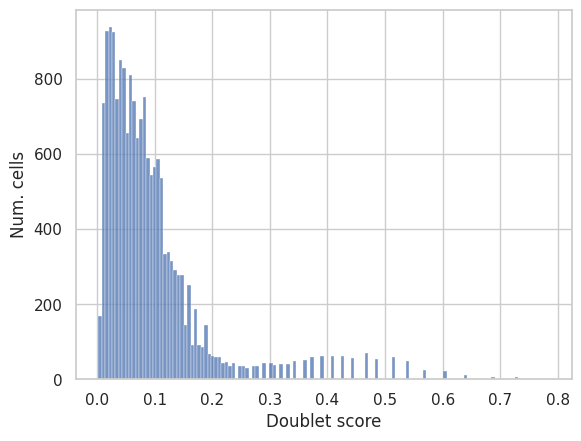

In [21]:
doublet_scores = pd.Series(doublet_scores, ad.obs_names)
predicted_doublets = pd.Series(predicted_doublets, ad.obs_names)
sns.histplot(doublet_scores);
plt.xlabel('Doublet score'); plt.ylabel('Num. cells');

doublet_scores[predicted_doublets].min(), predicted_doublets.mean(), predicted_doublets[emb.index.values].mean()

In [23]:
predicted_doublets = doublet_scores > 0.2

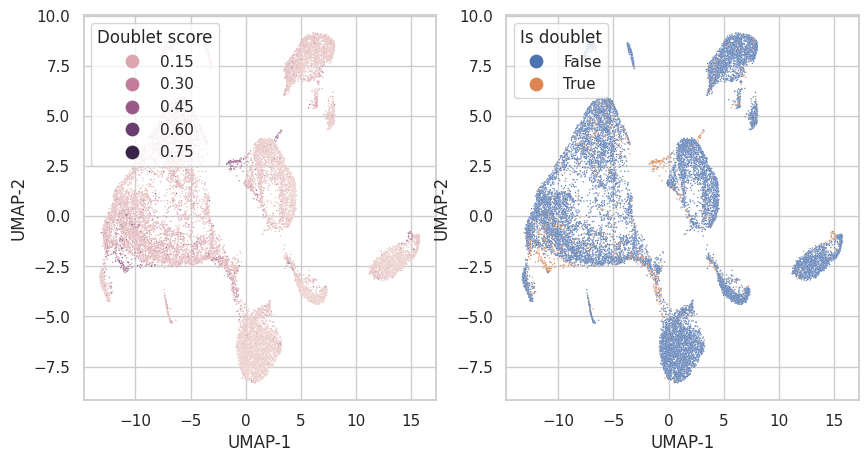

In [24]:
emb['doublet_score'] = doublet_scores[emb.index.values].values
emb['predicted_doublet'] = predicted_doublets[emb.index.values].values
ax1,ax2 = plt.subplots(1, 2, figsize=(10, 5))[1]
sns.scatterplot(data=emb, x='UMAP-1', y='UMAP-2', s=1, hue='doublet_score', ax=ax1)
sns.scatterplot(data=emb, x='UMAP-1', y='UMAP-2', s=1, hue='predicted_doublet', ax=ax2)
ax1.legend(markerscale=10, loc='upper left', title='Doublet score');
ax2.legend(markerscale=10, loc='upper left', title='Is doublet');

In [28]:
pd.DataFrame({
    'doublet_score': doublet_scores,
    'predicted_doublet': predicted_doublets,
    'barcode': doublet_scores.index
}).to_csv(f'{DATA_PATH}/processed/doublet_scores.csv', index=False)